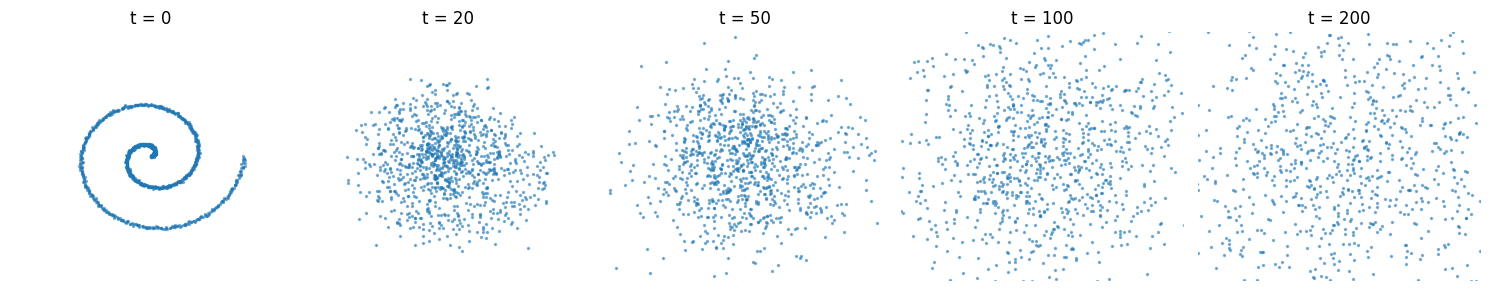

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# 1. Spiral data generator (with Scaling)
# -----------------------
def make_spiral(n_points=1000, noise=0.1):
    t = np.linspace(0, 4 * np.pi, n_points)
    x = t * np.cos(t)
    y = t * np.sin(t)
    data = np.stack([x, y], axis=1)
    data += noise * np.random.randn(*data.shape)

    # Scale data to be roughly between -1 and 1
    data = data / np.max(np.abs(data))
    return data

# -----------------------
# 2. Cosine Diffusion schedule
# -----------------------
def cosine_beta_schedule(timesteps, s=0.008):
    """
    Cosine schedule instead of linspace
    """
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, 0, 0.999)

T = 200
betas = cosine_beta_schedule(T)
alphas = 1.0 - betas
# Prepend 1.0 to alpha_bars so that alpha_bars[0] = 1.0 (Clean Data)
alpha_bars = np.cumprod(alphas)
alpha_bars = np.insert(alpha_bars, 0, 1.0)

# -----------------------
# 3. Forward diffusion
# -----------------------
def diffuse(x0, t, alpha_bars):
    # t=0 will use alpha_bars[0] which is 1.0 we did this cause we want pure image not a bit of noise at initial
    eps = np.random.randn(*x0.shape)
    mean_coef = np.sqrt(alpha_bars[t])
    noise_coef = np.sqrt(1 - alpha_bars[t])

    return mean_coef * x0 + noise_coef * eps

# -----------------------
# Run experiment
# -----------------------
x0 = make_spiral()
timesteps = [0, 20, 50, 100, 200] # T=200 is now the final noisy state

plt.figure(figsize=(15, 3))
for i, t in enumerate(timesteps):
    xt = diffuse(x0, t, alpha_bars)
    plt.subplot(1, len(timesteps), i + 1)
    plt.scatter(xt[:, 0], xt[:, 1], s=2, alpha=0.5)
    plt.title(f"t = {t}")
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.axis("off")

plt.tight_layout()
plt.show()

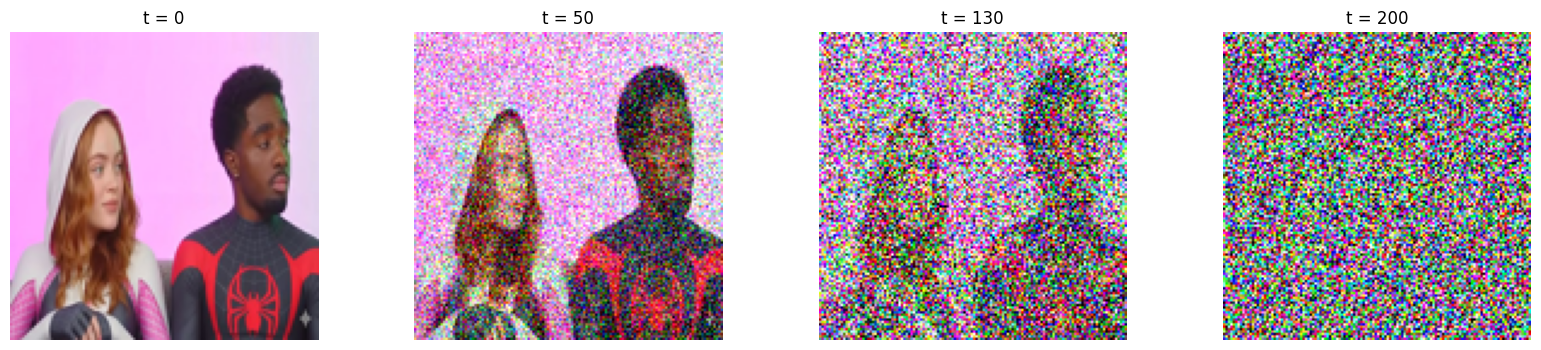

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# -----------------------
# 1. Download & Preprocess Image
# -----------------------
def get_image(url, size=(128, 128)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    img = img.resize(size)

    # Convert to numpy and scale to [-1, 1]
    img_array = np.array(img).astype(np.float32)
    img_array = (img_array / 127.5) - 1.0
    return img_array

# -----------------------
# 2. Diffusion Setup (Cosine Schedule)
# -----------------------
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, 0, 0.999)

T = 200
betas = cosine_beta_schedule(T)
alphas = 1.0 - betas
alpha_bars = np.insert(np.cumprod(alphas), 0, 1.0)

# -----------------------
# 3. Forward Diffusion
# -----------------------
def diffuse_image(x0, t, alpha_bars):
    noise = np.random.randn(*x0.shape)
    xt = np.sqrt(alpha_bars[t]) * x0 + np.sqrt(1 - alpha_bars[t]) * noise
    return xt

# -----------------------
# Run Experiment
# -----------------------
img_url = "https://i.pinimg.com/736x/c3/fe/78/c3fe7884e4fcb5cfa4f04b3216e77aaa.jpg"
x0 = get_image(img_url)

timesteps = [0, 50, 130, 200]
plt.figure(figsize=(20, 4))

for i, t in enumerate(timesteps):
    xt = diffuse_image(x0, t, alpha_bars)

    # Rescale back to [0, 1] for visualization
    display_img = (xt + 1.0) / 2.0
    display_img = np.clip(display_img, 0, 1)

    plt.subplot(1, len(timesteps), i + 1)
    plt.imshow(display_img)
    plt.title(f"t = {t}")
    plt.axis("off")

plt.show()